# Homework 4

### Import libraries

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from spectrum import *
from spectrum.linear_prediction import *
from scipy import signal

### Let matplotlib open a figure window

In [2]:
%matplotlib inline

### lpcFrames function

In [3]:
# create a function to compute lpcs per frame
def lpcFrames(x, P = 10, fs = 8000, doPlot = 1):
    '''
    x = sound waveform vector
    P = order of the LPC analysis (default 10)
    fs = the sampling rate in Hz (default 8000Hz)
    doPlot = flag for turning plots off (0) or on (1 = default)
    '''
    
    # set the frame size
    fSize = 512
    
    
    #the current frame number
    fNum = 0
    # the start index of the current frame
    fStart = 0
    # the end index of the current frame
    fEnd = fSize - 1
    # the frame hop size
    fHop = fSize / 2
    
    # length of input sound vector
    L = len(x)
    # calculated number of frames in x
    nFrames = int(np.floor(L/fHop) - 1)
    
    # create empty output array
    A = np.zeros((P+1, nFrames))
    
    # hanning window
    win = np.hanning(fSize)
    # frequency axis vector for plots
    f = (fs/2) * np.arange(fHop) / fHop
    
    if doPlot:
        fig, axes = plt.subplots(2,1,figsize=(18,12))
    
    while (fEnd < L - 1):
        
        # current frame of data
        frame = x[int(fStart):int(fEnd + 1)]
        # windowed frame
        wFrame = np.multiply(frame,win)
        # lpc polynomial a(z): H(z) = g/a(z)
        a, e = lpc(wFrame, P)
        # add one to beginning of a
        a = np.concatenate(([1],a),0)
        # collect lpc coefficients into output matrix
        A[:,fNum] = a.T
        
        # generate plots
        if doPlot:
            
            #plot windowed frame
            axes[0].plot(wFrame)
            
            plt.cla()
            
            # plot stft and lpc spectral envelope
            S = np.fft.fft(wFrame)
            w, h = signal.freqz(np.abs(e * 1024), a, int(fSize/2))
            hdb = 20 * np.log10(np.abs(h))
            sdb = 20 * np.log10(np.abs(S[:int(fSize/2)]))
            axes[1].plot(f, np.array([sdb,hdb]).T)
            
            plt.pause(0.05)
            
            axes[0].clear()
            axes[1].clear()
                 
        fStart = fStart + fHop
        fEnd = fEnd + fHop
        fNum = fNum + 1  
    return A

### Load audio file

In [4]:
filenames = ["Voices/male1.wav", "Voices/male2.wav", "Voices/female1.wav", "Voices/female2.wav", "Voices/female3.wav"]
X = {}
for fname in filenames:
    x, sr = librosa.load(fname)
    X[fname] = (x, sr)

In [5]:
len(X)

5

### Compute LPC frames

In [6]:
A = {}
for fname in filenames:
    A[fname] = lpcFrames(X[fname][0],doPlot=0)

### Your answers

#### (a)

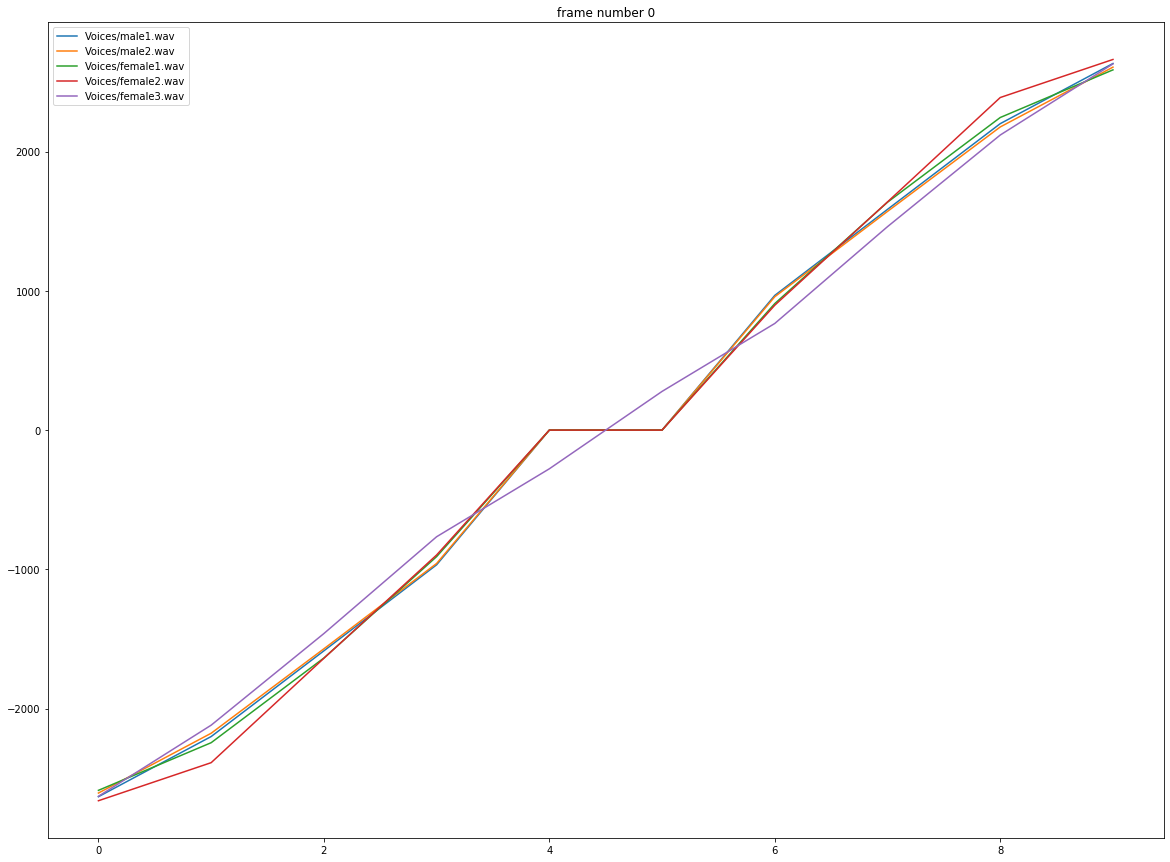

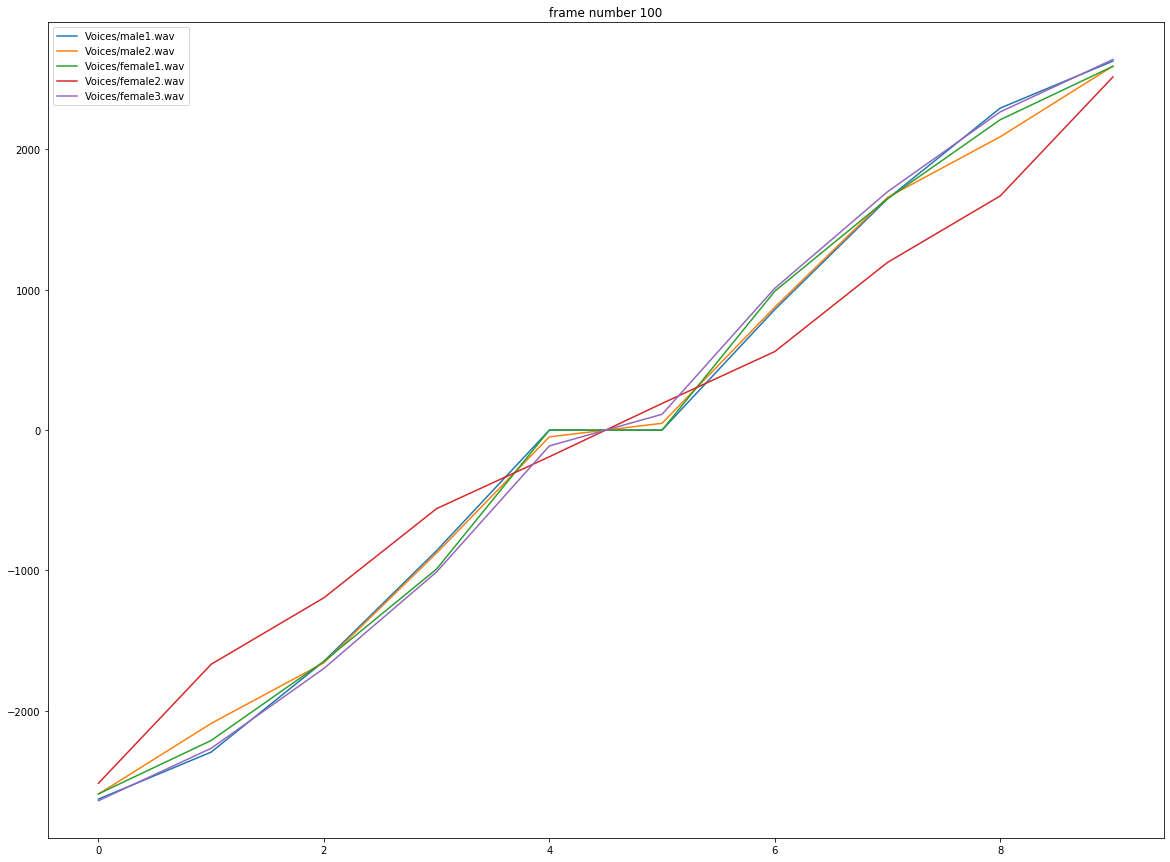

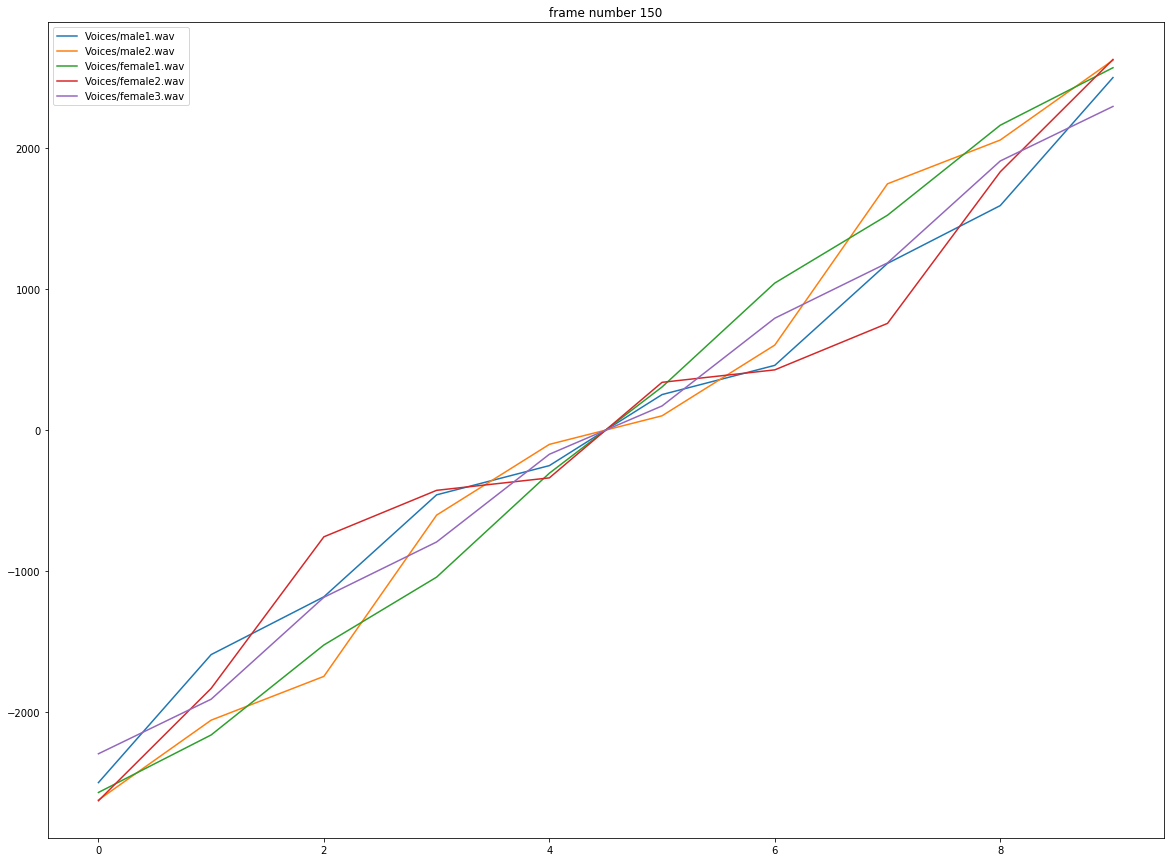

In [7]:
def get_pole_angles(A, fs=8000):
    pole_angles = np.zeros((A.shape[0]-1, A.shape[1]))
    for i in range(0, A.shape[1]):
        pole_angles[:,i] = sorted(np.angle(np.roots(A[:,i])))
    pole_angles = pole_angles/np.pi*(fs/2)
    return pole_angles

frames = [0, 100, 150];
for fr in frames:
    plt.figure(figsize=(20,15))
    for fname in filenames:
        pole_angles = get_pole_angles(A[fname])
        plt.plot(pole_angles[:,fr], label=fname)
    plt.legend(loc='upper left')
    plt.title("frame number {}".format(fr))
    plt.pause(0.05)

#### (b)

Since the roots of the columns of A come in complex conjugate pairs, the extracted angles are symmetric at $y=0$. Hence, it would be better to filter out the negative frequencies. However, this will cause the number of frequencies per frame to be divided in half (5 instead of 10), which will cause some information to be lost. Also, it is seen from the graph that some voices' pole angles' patterns are very different from all of the other voices. Hence, it can be difficult to know which pattern should be picked.

#### (c)

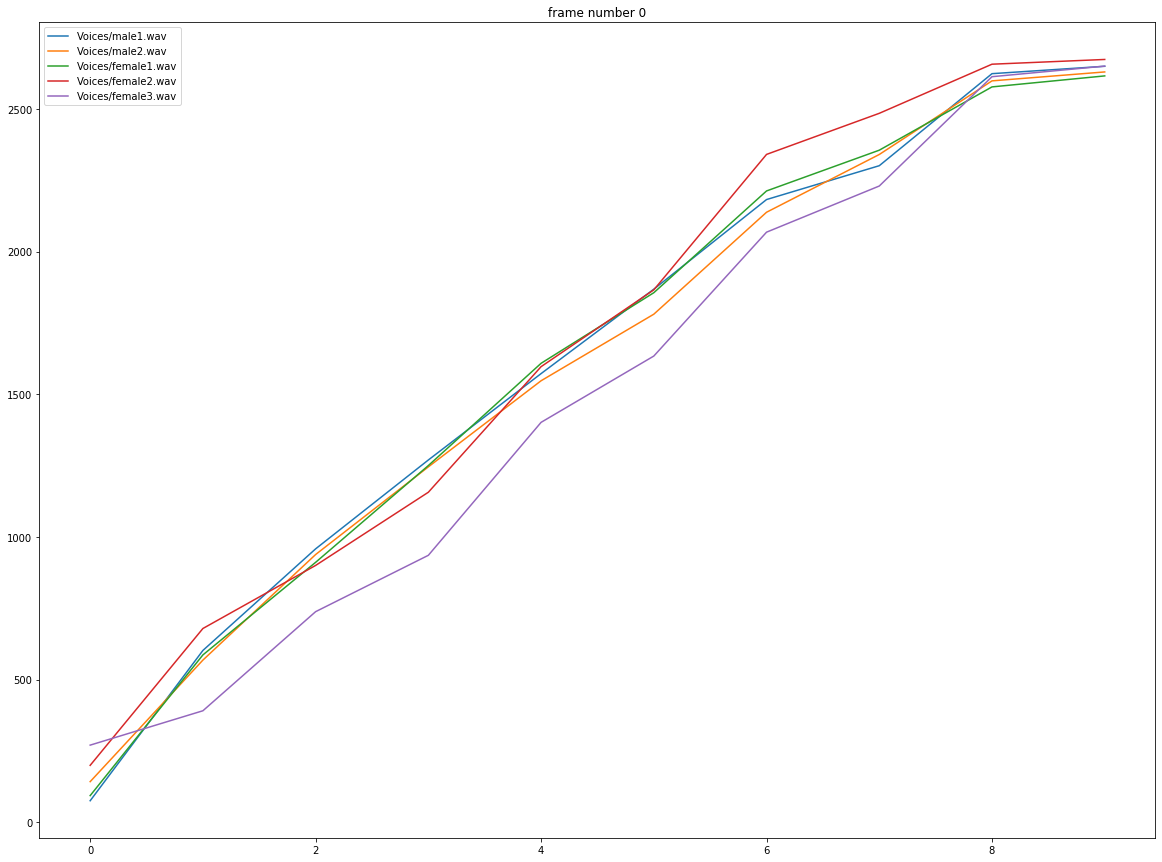

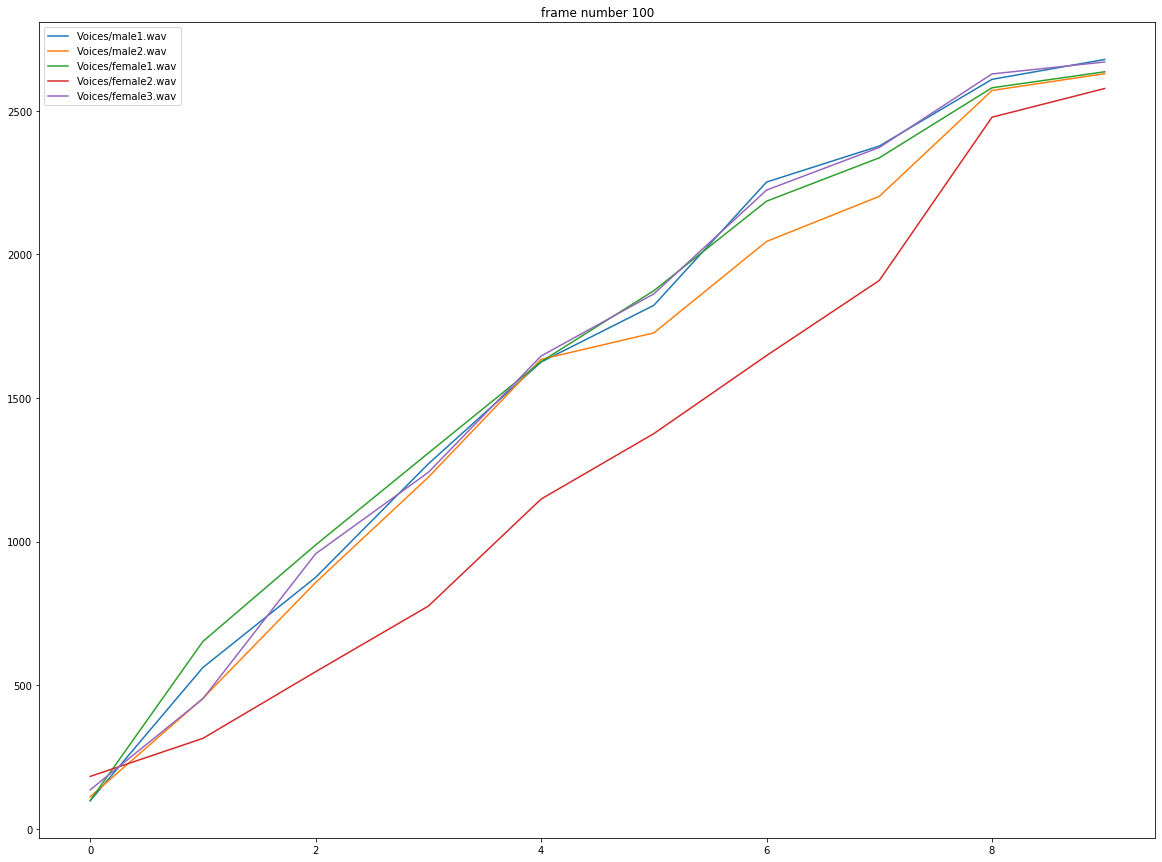

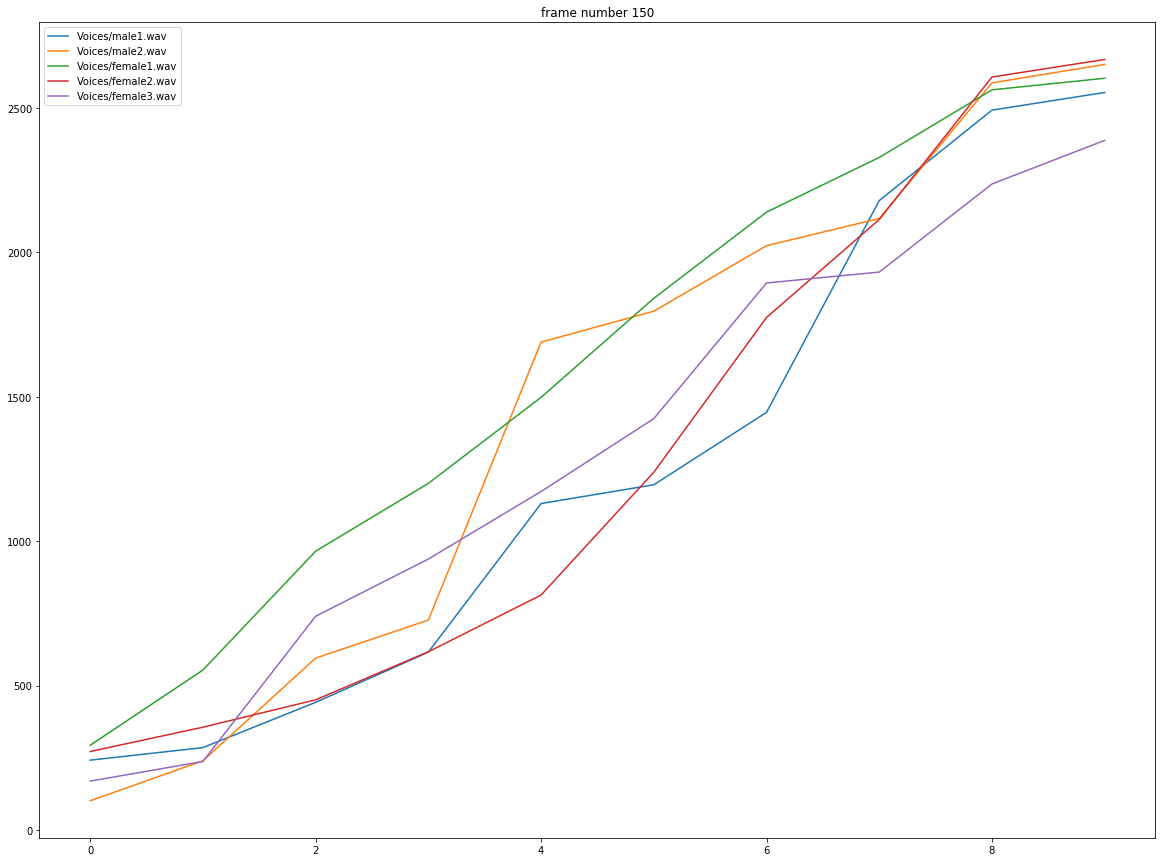

In [8]:
def get_lsf(A, fs=8000):
    lsf = np.zeros((A.shape[0]-1, A.shape[1]))
    for i in range(0, A.shape[1]):
        lsf[:,i] = poly2lsf(A[:,i])
    lsf = lsf/np.pi*(fs/2)
    return lsf

frames = [0, 100, 150];
for fr in frames:
    plt.figure(figsize=(20,15))
    for fname in filenames:
        lsf = get_lsf(A[fname])
        plt.plot(lsf[:,fr], label=fname)
    plt.legend(loc='upper left')
    plt.title("frame number {}".format(fr))
    plt.pause(0.05)
    

#### (d)

The LSF is better suited for identifying phonemems than the pole angles because LSF only contains positive frequencies, which means that there is no need to cut the freq vector in half, hence, higher resolution. Also, LSF is less susceptible to noise, which makes identifying phonemems patterns easier. From the graph, there are still frames where the voice's pattern don't exactly match. However, their curve shapes do match better than that in part (a).